In [44]:
###########################################################
import numpy as np
random_seed = 37
np.random.seed(random_seed)
from tensorflow import set_random_seed
set_random_seed(random_seed)
###########################################################

import os
from keras.layers import Dense, GRU, LSTM, CuDNNGRU, CuDNNLSTM, Activation, LSTMCell, GRUCell, Conv1D, MaxPool1D, Flatten, TimeDistributed, Reshape, Input
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
# from keras_tqdm import TQDMNotebookCallback

from utils import plot_train_history, save_train_history, load_train_history

# Load training dataset
PAST_WINDOW_SIZE = 16
FUTURE_WINDOW_SIZE = 0
N_FEATURES = 6
# N_FEATURES = 12
seq_len = PAST_WINDOW_SIZE + FUTURE_WINDOW_SIZE
dataset_filename = f'/home/ICT2000/jondras/datasets/vra1/final_datasets/dataset_padded_{PAST_WINDOW_SIZE}pws_{FUTURE_WINDOW_SIZE}fws_{N_FEATURES}f.npz'
data = np.load(dataset_filename)
X, y = data['X_train'], data['y_train']
print(X.shape, y.shape)


(39786, 16, 6) (39786,)


In [45]:
# Split into train and validation partitions (stratified split)
val_size = 0.15

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=random_seed, stratify=y)
print(f'Train examples per class: {np.unique(y_train, return_counts=True)}')
print(f'Test examples per class: {np.unique(y_val, return_counts=True)}')
# Train examples per class: (array([0, 1]), array([17553, 17553]))
# Test examples per class: (array([0, 1]), array([5851, 5851]))


Train examples per class: (array([0, 1]), array([16909, 16909]))
Test examples per class: (array([0, 1]), array([2984, 2984]))


In [50]:
# Model
# model = Sequential()
# model.add(GRU(20, input_shape = (seq_len, N_FEATURES), return_sequences=True))
# model.add(GRU(1, return_sequences = False))
# model.add(Activation('sigmoid'))
# model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


# print(model.summary())

GRU_units = [128]

model = Sequential()

# Insufficient input rank
# model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'), 
#                           batch_input_shape = (None, None, seq_len, N_FEATURES)))
# model.add(TimeDistributed(MaxPool1D(pool_size=2)))
# model.add(TimeDistributed(Flatten()))

#  model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'), 
#                            input_shape = (32, seq_len, N_FEATURES)))
# td_max = TimeDistributed(MaxPool1D(pool_size=2))

td_dense = TimeDistributed(Dense(64), input_shape = (seq_len, N_FEATURES))
# td_conv1 = TimeDistributed(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'), 
#                                   input_shape = (None, 32, seq_len, N_FEATURES))
model.add(td_dense)
# model.add(td_max)
# model.add(Reshape((seq_len, 32 * N_FEATURES)))
# model.add(TimeDistributed(Flatten()))

# model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape = (seq_len, N_FEATURES)))
# model.add(MaxPool1D(pool_size=2))

# model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPool1D(pool_size=2))

# model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPool1D(pool_size=2))

# model.add(GRU(GRU_units[0], return_sequences=False))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(td_dense.input_shape)
# print(model.summary())

(None, 16, 6)


In [4]:
# Train
# model.fit(X_train, y_train, batch_size=10, epochs=5, verbose=0, callbacks=[TQDMNotebookCallback()])

n_epochs = 100
batch_size = 32

# Set early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Checkpoint model weights and the model itself: at each epoch
model_type = f'{GRU_units[0]}u_{PAST_WINDOW_SIZE}pws_{FUTURE_WINDOW_SIZE}fws_{N_FEATURES}f'
print(f'INFO:\n\t{model_type}\n\tbatch_size={batch_size}\n\tn_epochs={n_epochs}')
model_checkpoint_path_prefix = f'./checkpoints/{model_type}/'
if not os.path.exists(model_checkpoint_path_prefix):
    os.makedirs(model_checkpoint_path_prefix)
model_checkpoint_name = 'm_{epoch:04d}_{loss:.4f}_{val_loss:.4f}.hdf5'
model_checkpoint = ModelCheckpoint(model_checkpoint_path_prefix + model_checkpoint_name, monitor='val_loss', verbose=1, 
                                   save_best_only=True, save_weights_only=False, mode='auto', period=1)

hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=n_epochs, verbose=1, 
                 callbacks=[
                     model_checkpoint,
                     early_stop
                 ], shuffle=True)

# Save training history
save_train_history(hist, model_type)

INFO:
	128u_16pws_0fws_6f
	batch_size=32
	n_epochs=100
Instructions for updating:
Use tf.cast instead.
Train on 33818 samples, validate on 5968 samples
Epoch 1/100
33818/33818 [==============================] - 39s 1ms/step - loss: 0.4382 - acc: 0.7949 - val_loss: 0.3841 - val_acc: 0.8448

Epoch 00001: val_loss improved from inf to 0.38407, saving model to ./checkpoints/128u_16pws_0fws_6f/m_0001_0.4382_0.3841.hdf5
Epoch 2/100
33818/33818 [==============================] - 36s 1ms/step - loss: 0.3410 - acc: 0.8572 - val_loss: 0.3238 - val_acc: 0.8636

Epoch 00002: val_loss improved from 0.38407 to 0.32380, saving model to ./checkpoints/128u_16pws_0fws_6f/m_0002_0.3410_0.3238.hdf5
Epoch 3/100
33818/33818 [==============================] - 36s 1ms/step - loss: 0.3104 - acc: 0.8713 - val_loss: 0.3046 - val_acc: 0.8784

Epoch 00003: val_loss improved from 0.32380 to 0.30464, saving model to ./checkpoints/128u_16pws_0fws_6f/m_0003_0.3104_0.3046.hdf5
Epoch 4/100
33818/33818 [=================

In [ ]:
# import importlib
# importlib.reload(utils)
# from utils import plot_train_history, save_train_history, load_train_history

In [ ]:
load_train_history('128u_16pws_0fws_6f')
# 6 features, 128 units - converges slower

Min train loss: 0.03550855957642612 @epoch 22 	 Max train acc: 0.9881424093466421 @epoch 22
Min valid loss: 0.19993099623207433 @epoch 12 	 Max valid acc: 0.9440348525469169 @epoch 20


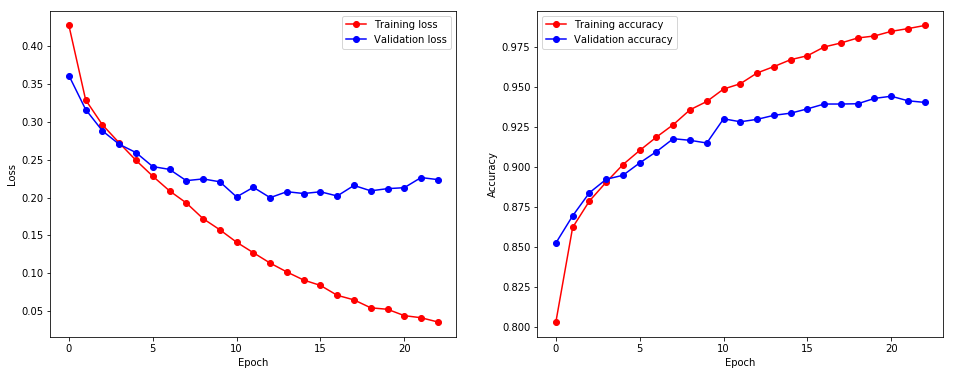

In [22]:
load_train_history('128u_16pws_0fws_12f')
# 12 features, 128 units

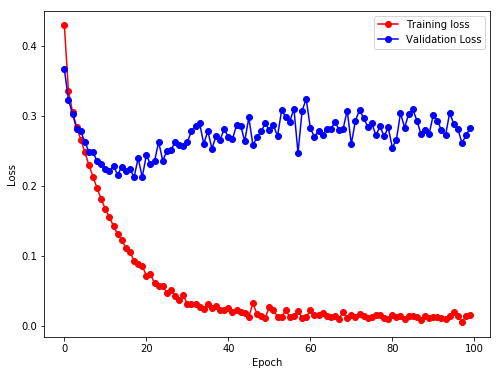

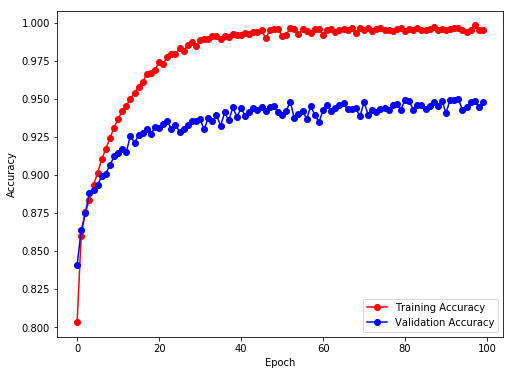

In [14]:
from utils import plot_train_history
plot_train_history(hist)

In [8]:
# Evaluate
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

11702/11702 [==============================] - 4s 361us/step
Accuracy: 80.61%


In [ ]:
# k-fold cross-validation

https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/